In [1]:
import jax
import jax.scipy.linalg
import jax.numpy as jnp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from glue_module.glue_analysis import run_glue_solver, make_plots
import numpy as np
from jaxopt import OSQP

print(f"Using {jax.devices()}")
qp = OSQP(tol=1e-4)

Using [CudaDevice(id=0)]


In [2]:
def generate_gmm_data(key, means, sigma, points_per_centroid):
    """
    Generates synthetic classification data based on Gaussian clusters.
    
    Args:
        key: jax.random.PRNGKey
        means: Array of shape (P, mu_count, N) defining centroid locations.
        sigma: Float representing standard deviation (uniform scalar).
        points_per_centroid: Int, number of points to generate per centroid.
        
    Returns:
        points: Array of shape (P, total_points_per_class, N)
    """
    # 1. Extract dimensions from the means array
    P, mu_count, N = means.shape
    # 2. Generate Noise
    noise_shape = (P, mu_count, points_per_centroid, N)
    epsilon = jax.random.normal(key, shape=noise_shape)
    # 3. Broadcast Means
    means_expanded = means[:, :, jnp.newaxis, :]
    # 4. Apply Gaussian transformation: X = mu + sigma * noise
    raw_points = means_expanded + (sigma * epsilon)
    # 5. Reshape to required output
    points = raw_points.reshape(P, -1, N)
    return points

In [3]:
def plot_data(data):
    """
    Plots generated GMM data in 2D or 3D based on the feature dimension N.
    
    Args:
        data: JAX array of shape (P, n_total_points, N)
        means: Optional JAX array of shape (P, mu_count, N) for plotting centroids
    """
    P, n_points, N = data.shape
    colors = [
        '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', 
        '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'
    ]
    # --- Setup Figure ---
    fig = plt.figure(figsize=(6, 4))
    # --- Check Dimensionality ---
    if N == 2:
        ax = fig.add_subplot(111)
        ax.set_title(f"2D Data Visualization\nShape: {data.shape}")
    elif N == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(f"3D Data Visualization\nShape: {data.shape}")
    else:
        raise ValueError(f"Plotting only supported for N=2 or N=3, but got N={N}")

    # --- Plotting Loop ---
    for i in range(P):
        c = colors[i % len(colors)]
        class_points = data[i]
        
        # 2D Plotting
        if N == 2:
            ax.scatter(class_points[:, 0], 
                       class_points[:, 1], 
                       label=f"Class {i}", 
                       c=c)
                
        # 3D Plotting
        elif N == 3:
            ax.scatter(class_points[:, 0], 
                       class_points[:, 1], 
                       class_points[:, 2], 
                       label=f"Class {i}", 
                       c=c)
# --- Labels and Grid (Origin lines only) ---
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    
    # Remove standard grid
    ax.grid(False)

    if N == 2:
        # Draw X and Y lines at 0
        ax.axhline(0, color='black', linewidth=1.2, zorder=1)
        ax.axvline(0, color='black', linewidth=1.2, zorder=1)
    elif N == 3:
        ax.set_zlabel("Feature 3")
        # Draw X, Y, and Z lines through the origin
        # We use get_xlim etc. to ensure lines span the current view
        xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
        ax.plot(xlim, [0, 0], [0, 0], color='black', linewidth=1.2) # X-axis
        ax.plot([0, 0], ylim, [0, 0], color='black', linewidth=1.2) # Y-axis
        ax.plot([0, 0], [0, 0], zlim, color='black', linewidth=1.2) # Z-axis
        
    ax.legend()
    plt.show()

### Well Separated Two Classes

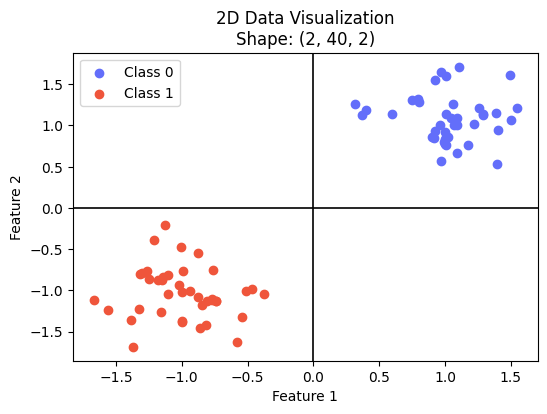

In [4]:
P = 2
n_points_per_cloud = 40
M = 30
N = 2
n_t = 40
sigma = 0.3
mus = jnp.array([[[1.0, 1.0]],[[-1.0, -1.0]]])
key = jax.random.PRNGKey(42)
data_key, key = jax.random.split(key)

# Generate the data
data = generate_gmm_data(data_key, mus, sigma, n_points_per_cloud)

plot_data(data)

In [5]:
gl_key, key = jax.random.split(key)
geometries, plotting_inputs = run_glue_solver(gl_key, data, P, M, N, n_t, qp)

In [6]:
print("Functional GLUE geos:")
for g in geometries:
    print(g)

Functional GLUE geos:
1.164564
0.9505655
3.3399022
0.79880315
0.90875417
-0.049103837
1.1463138


In [7]:
fn_figs = make_plots(*plotting_inputs, n_plots=3)

In [8]:
for f in fn_figs:
    f.show()

### Validation
I will validate the accuracy of the model by generating toy data given known manifold metrics and then compare the computed values with true values. 

In [9]:
from functools import partial

# We add 'max_D' to static_argnames so JAX knows the array shapes at compile time.
# P, N, n_points are also static as requested.
@partial(jax.jit, static_argnames=('P', 'N', 'n_points', 'D')) 
def generate_glue_ground_truth_data(key, P, N, n_points, R, D, rho_c, rho_a, psi):
    """
    Optimized generation of P point clouds with dynamic manifold dimension D.
    
    Args:
        max_D: A static upper bound for D. Allocates arrays of this size 
               to avoid recompilation when D changes.
    """
    # Split keys
    k_c, k_b, k_pts = jax.random.split(key, 3)
    
    # Scale factor
    scale = N**(-0.25)
    
    # --- Analytic Mixing Coefficients ---
    # Clip for numerical stability
    c_unique_c = jnp.sqrt(jnp.maximum(1.0 - rho_c**2, 1e-10))
    c_common_c = rho_c
    
    c_unique_a = jnp.sqrt(jnp.maximum(1.0 - rho_a**2, 1e-10))
    c_common_a = rho_a

    # --- Step 1 & 2: Generate Correlated Centers (u_0) ---
    # Shape: (P, N) - Independent of D, so logic remains identical
    k_c_u, k_c_s = jax.random.split(k_c)
    U_c_unique = jax.random.normal(k_c_u, (P, N)) * scale
    U_c_shared = jax.random.normal(k_c_s, (1, N)) * scale
    
    centers = c_unique_c * U_c_unique + c_common_c * U_c_shared

    # Bases
    k_b_u, k_b_s = jax.random.split(k_b)
    U_b_unique = jax.random.normal(k_b_u, (D, P, N)) * scale
    U_b_shared = jax.random.normal(k_b_s, (D, 1, N)) * scale
    
    bases = c_unique_a * U_b_unique + c_common_a * U_b_shared
    bases = jnp.swapaxes(bases, 0, 1) # (P, D, N)

    # Noise
    k_pts_a, k_pts_b = jax.random.split(k_pts)
    a_j = jax.random.normal(k_pts_a, (P, n_points, 1)) * psi
    
    # Sample directly in R^D
    raw_b = jax.random.normal(k_pts_b, (P, n_points, D))
    norms = jnp.linalg.norm(raw_b, axis=2, keepdims=True)
    b_j = raw_b / (norms + 1e-9)
    
    # Matrix Multiplication
    # This is now lightning fast for small D
    intrinsic_variation = jnp.matmul(b_j, bases)
    
    # 4. Combine
    # centers: (P, N) -> (P, 1, N)
    longitudinal_part = (1 + a_j) * centers[:, None, :]
    
    # Result shape is (P, n_points, N), which is static given P, N, n_points
    points = longitudinal_part + (R * intrinsic_variation)
    
    return points, centers

In [10]:
def plot_glue_data(data, centers=None):
    """
    Plots GLUE data in 2D or 3D based on the feature dimension N.
    
    Args:
        data: Array of shape (P, n_points, N)
        centers: Optional array of shape (P, N) for centroids
    """
    P, n_points, N = data.shape
    colors = [
        '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', 
        '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'
    ]
    
    fig = plt.figure(figsize=(8, 6))
    
    # --- Check Dimensionality ---
    if N == 2:
        ax = fig.add_subplot(111)
        ax.set_title(f"2D GLUE Data (N={N})")
    elif N == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(f"3D GLUE Data (N={N})")
    else:
        # Fallback for High-D: Plot first 2 dims
        ax = fig.add_subplot(111)
        ax.set_title(f"Projected GLUE Data (First 2 of {N} dims)")
        
    # --- Plotting Loop ---
    for i in range(P):
        c = colors[i % len(colors)]
        points = data[i] # Shape (n_points, N)
        
        label = f"Manifold {i}"
        
        if N == 2 or (N > 3):
            # Plot 2D
            ax.scatter(points[:, 0], points[:, 1], 
                       label=label, c=c, alpha=0.6, s=20)
            
            if centers is not None:
                ax.scatter(centers[i, 0], centers[i, 1], 
                           c='black', marker='x', s=100, linewidth=2, zorder=5)
                
        elif N == 3:
            # Plot 3D
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                       label=label, c=c, alpha=0.6, s=20)
            
            if centers is not None:
                ax.scatter(centers[i, 0], centers[i, 1], centers[i, 2], 
                           c='black', marker='x', s=100, linewidth=2, zorder=5)

    # --- Formatting ---
    ax.grid(False)
    
    # Draw axes lines through origin
    if N == 2 or (N > 3):
        ax.axhline(0, color='black', linewidth=1, zorder=1)
        ax.axvline(0, color='black', linewidth=1, zorder=1)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
    elif N == 3:
        # For 3D, standard axis labels
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.set_zlabel("Dim 3")
        # Draw origin lines manually if desired, or rely on box
        xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
        ax.plot(xlim, [0,0], [0,0], 'k-', lw=1, alpha=0.5)
        ax.plot([0,0], ylim, [0,0], 'k-', lw=1, alpha=0.5)
        ax.plot([0,0], [0,0], zlim, 'k-', lw=1, alpha=0.5)

    plt.legend()
    plt.show()

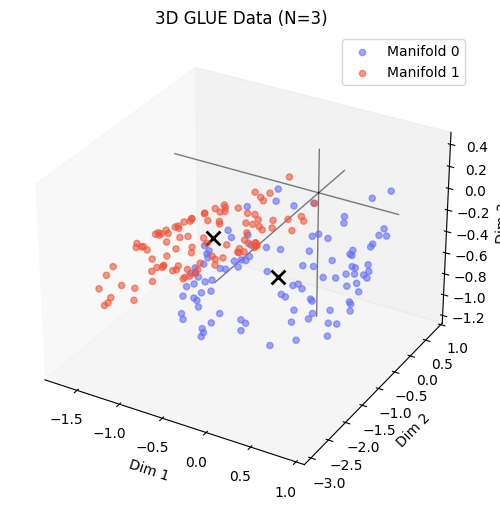

In [11]:
# --- Runnable Example (N=3) ---
# Parameters adjusted for visual validation in 3D
P = 2
n_points = 100
N = 3          # Set to 2 or 3 to test
D = 2          # Intrinsic dimension (1=line, 2=plane)
R = 0.5        # Radius
M = 40
rho_c = 0.9    # Center correlation (Close centers)
rho_a = 0.2    # Axis correlation
psi = 0.3      # Center-axis correlation

ground_truth = [D, R, rho_c, rho_a, psi]

d_key, key = jax.random.split(key)
# Generate
data, centers = generate_glue_ground_truth_data(
    d_key, P, N, n_points, R, D, rho_c, rho_a, psi
)

# Plot
plot_glue_data(data, centers)

In [12]:
gl_key, key = jax.random.split(key)
geometries, plotting_inputs = run_glue_solver(gl_key, data, P, M, N, n_t, qp)

In [13]:
print("GT glue values:")
for g in ground_truth:
    print(g)
print("Functional GLUE geos:")
for g in geometries:
    print(g)

GT glue values:
2
0.5
0.9
0.2
0.3
Functional GLUE geos:
0.6695708
1.3802341
2.2372077
-0.8860246
-0.88572234
-0.12158398
0.86927015


### 2D check with known values

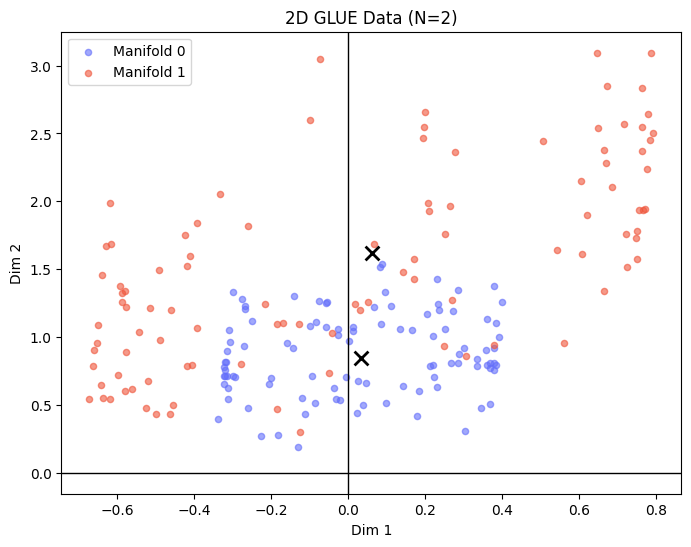

In [14]:
P = 2
n_points = 100
N = 2          # Set to 2 or 3 to test
D = 2          # Intrinsic dimension (1=line, 2=plane)
R = 0.5        # Radius
M = 40
rho_c = 0.9    # Center correlation (Close centers)
rho_a = 0.2   # Axis correlation
psi = 0.3      # Center-axis correlation

ground_truth = [D, R, rho_c, rho_a, psi]

d_key, key = jax.random.split(key)

# Generate
data, centers = generate_glue_ground_truth_data(
    d_key, P, N, n_points, R, D, rho_c, rho_a, psi
)

# Plot
plot_glue_data(data, centers)

In [15]:
gl_key, key = jax.random.split(key)
geometries, plotting_inputs = run_glue_solver(gl_key, data, P, M, N, n_t, qp)

In [16]:
print("GT glue values:")
for g in ground_truth:
    print(g)
print("GLUE geos:")
for g in geometries:
    print(g)

GT glue values:
2
0.5
0.9
0.2
0.3
GLUE geos:
0.791649
1.2631865
14.2670355
-0.9759509
-0.89686626
-0.08980141
0.795538


### Recreating the papers figure S6

In [ ]:
import gc

# --- 1. Setup Parameters ---
P = 2
N = 40
M = 100
n_points = M
rho_c = 0.0
rho_a = 0.0
psi = 0.0
n_t = 100
n_reps = 20


# Scan Ranges (Mesh Grid)
radii_scan = jnp.linspace(0.2, 2.0, 10)
dims_scan = [2, 4, 6, 8, 10]

main_key = jax.random.PRNGKey(0)

# --- 2. Phase 1: Data Generation ---

@partial(jax.jit, static_argnames=['D', 'n_reps'])
def generate_batch_data(key, radii_array, D, n_reps):
    """
    Generates ALL data for a specific Dimension D.
    Output Shape: (n_radii, n_reps, [Data Shape...])
    """
    n_radii = radii_array.shape[0]
    
    # 1. Create a grid of keys: (n_radii, n_reps)
    keys = jax.random.split(key, n_radii * n_reps)
    keys = keys.reshape(n_radii, n_reps, -1)
    
    # 2. Define single generation function
    def generate_single(k, r):
        # We only keep 'data' here for the solver, it returns data, centers
        d, _ = generate_glue_ground_truth_data(
            k, P, N, n_points, r, D, rho_c, rho_a, psi
        )
        return d

    # 3. Vectorize over Reps (inner), Map over Radii (outer)
    # vmap over keys (axis 0), broadcast radius
    vmapped_gen = jax.vmap(generate_single, in_axes=(0, None))
    
    # scan/map over radii
    # We map over (keys[i], radii_array[i])
    def scan_gen(keys_batch, r):
        return vmapped_gen(keys_batch, r)

    batch_data = jax.lax.map(lambda args: scan_gen(*args), (keys, radii_array))
    
    return batch_data

# --- 3. Phase 2: Solver Execution ---
@jax.jit
def solve_batch_scan(key, batch_data):
    """
    Solves a pre-generated batch of data.
    Input Data Shape: (n_radii, n_reps, ...)
    """
    n_radii = batch_data.shape[0]
    n_reps = batch_data.shape[1]
    
    # Prepare keys for the solver phase
    # One key per (radius, rep)
    keys = jax.random.split(key, n_radii * n_reps)
    keys = keys.reshape(n_radii, n_reps, -1)

    # Define single solver run
    def run_single_solve(k, d):
        metrics, _ = run_glue_solver(k, d, P, M, N, n_t, qp)
        # Extract metrics: [Capacity, Theory_D, Theory_R, CapApprox]
        return jnp.stack([metrics[0], metrics[1], metrics[2], metrics[3]])

    # Define the scanning function (over Radii)
    def scan_body(carry, x):
        # x contains: (keys_for_this_radius_batch, data_for_this_radius_batch)
        batch_keys, batch_data_slice = x
        
        # Vmap over the repetitions
        batch_results = jax.vmap(run_single_solve)(batch_keys, batch_data_slice)
        
        # Calculate stats for this radius (mean/std over the reps axis)
        # batch_results shape: (n_reps, 4)
        means = jnp.mean(batch_results, axis=0) # Shape (4,)
        stds = jnp.std(batch_results, axis=0)   # Shape (4,)
        
        # Interleave mean/std: [Mean_Cap, Std_Cap, Mean_D, Std_D, ...]
        # Stack them to get shape (8,)
        stats = jnp.ravel(jnp.stack([means, stds], axis=1))
        
        return carry, stats # Carry is unused but required for scan

    # Run the scan
    # We scan over the leading axis of keys and batch_data
    _, results_stack = jax.lax.scan(scan_body, None, (keys, batch_data))
    
    return results_stack

# --- 4. Main Execution Loop ---

print(f"--- Starting Decoupled Scan ---")
results_collection = []

for i, D in enumerate(dims_scan):
    print(f"Processing Dimension D={D}...", flush=True)
    
    # Split keys for this dimension
    main_key, gen_key, solve_key = jax.random.split(main_key, 3)
    
    # --- PHASE 1: GENERATE ---
    # Result: (n_radii, n_reps, Data_Dim...)
    data_batch = generate_batch_data(gen_key, radii_scan, D, n_reps)
    
    # Optional: Force computation to ensure memory is actually allocated/managed
    data_batch.block_until_ready()
    
    # --- PHASE 2: SOLVE ---
    # Result: (n_radii, 8)
    print(f"  > Running Solver...", flush=True)
    dim_results = solve_batch_scan(solve_key, data_batch)
    dim_results.block_until_ready()
    
    results_collection.append(dim_results)
    # Help the allocator see what's no longer needed
    del data_batch
    gc.collect()


# --- 5. Post-Processing ---

all_results_tensor = jnp.stack(results_collection)

results_grid = {
    'scan_dims': jnp.array(dims_scan),
    'scan_radii': radii_scan,
    'grid_means_Cap': all_results_tensor[:, :, 0],
    'grid_stds_Cap':  all_results_tensor[:, :, 1],
    'grid_means_D':   all_results_tensor[:, :, 2],
    'grid_stds_D':    all_results_tensor[:, :, 3],
    'grid_means_R':   all_results_tensor[:, :, 4],
    'grid_stds_R':    all_results_tensor[:, :, 5],
    'grid_means_CapApprox': all_results_tensor[:, :, 6],
    'grid_stds_CapApprox':  all_results_tensor[:, :, 7],
}

# 1m 4.1s with D=[2,4,6,8], N=10, M=

--- Starting Decoupled Scan ---
Processing Dimension D=2...
  > Running Solver...
Processing Dimension D=4...
  > Running Solver...
Processing Dimension D=6...
  > Running Solver...
Processing Dimension D=8...
  > Running Solver...
Processing Dimension D=10...
  > Running Solver...


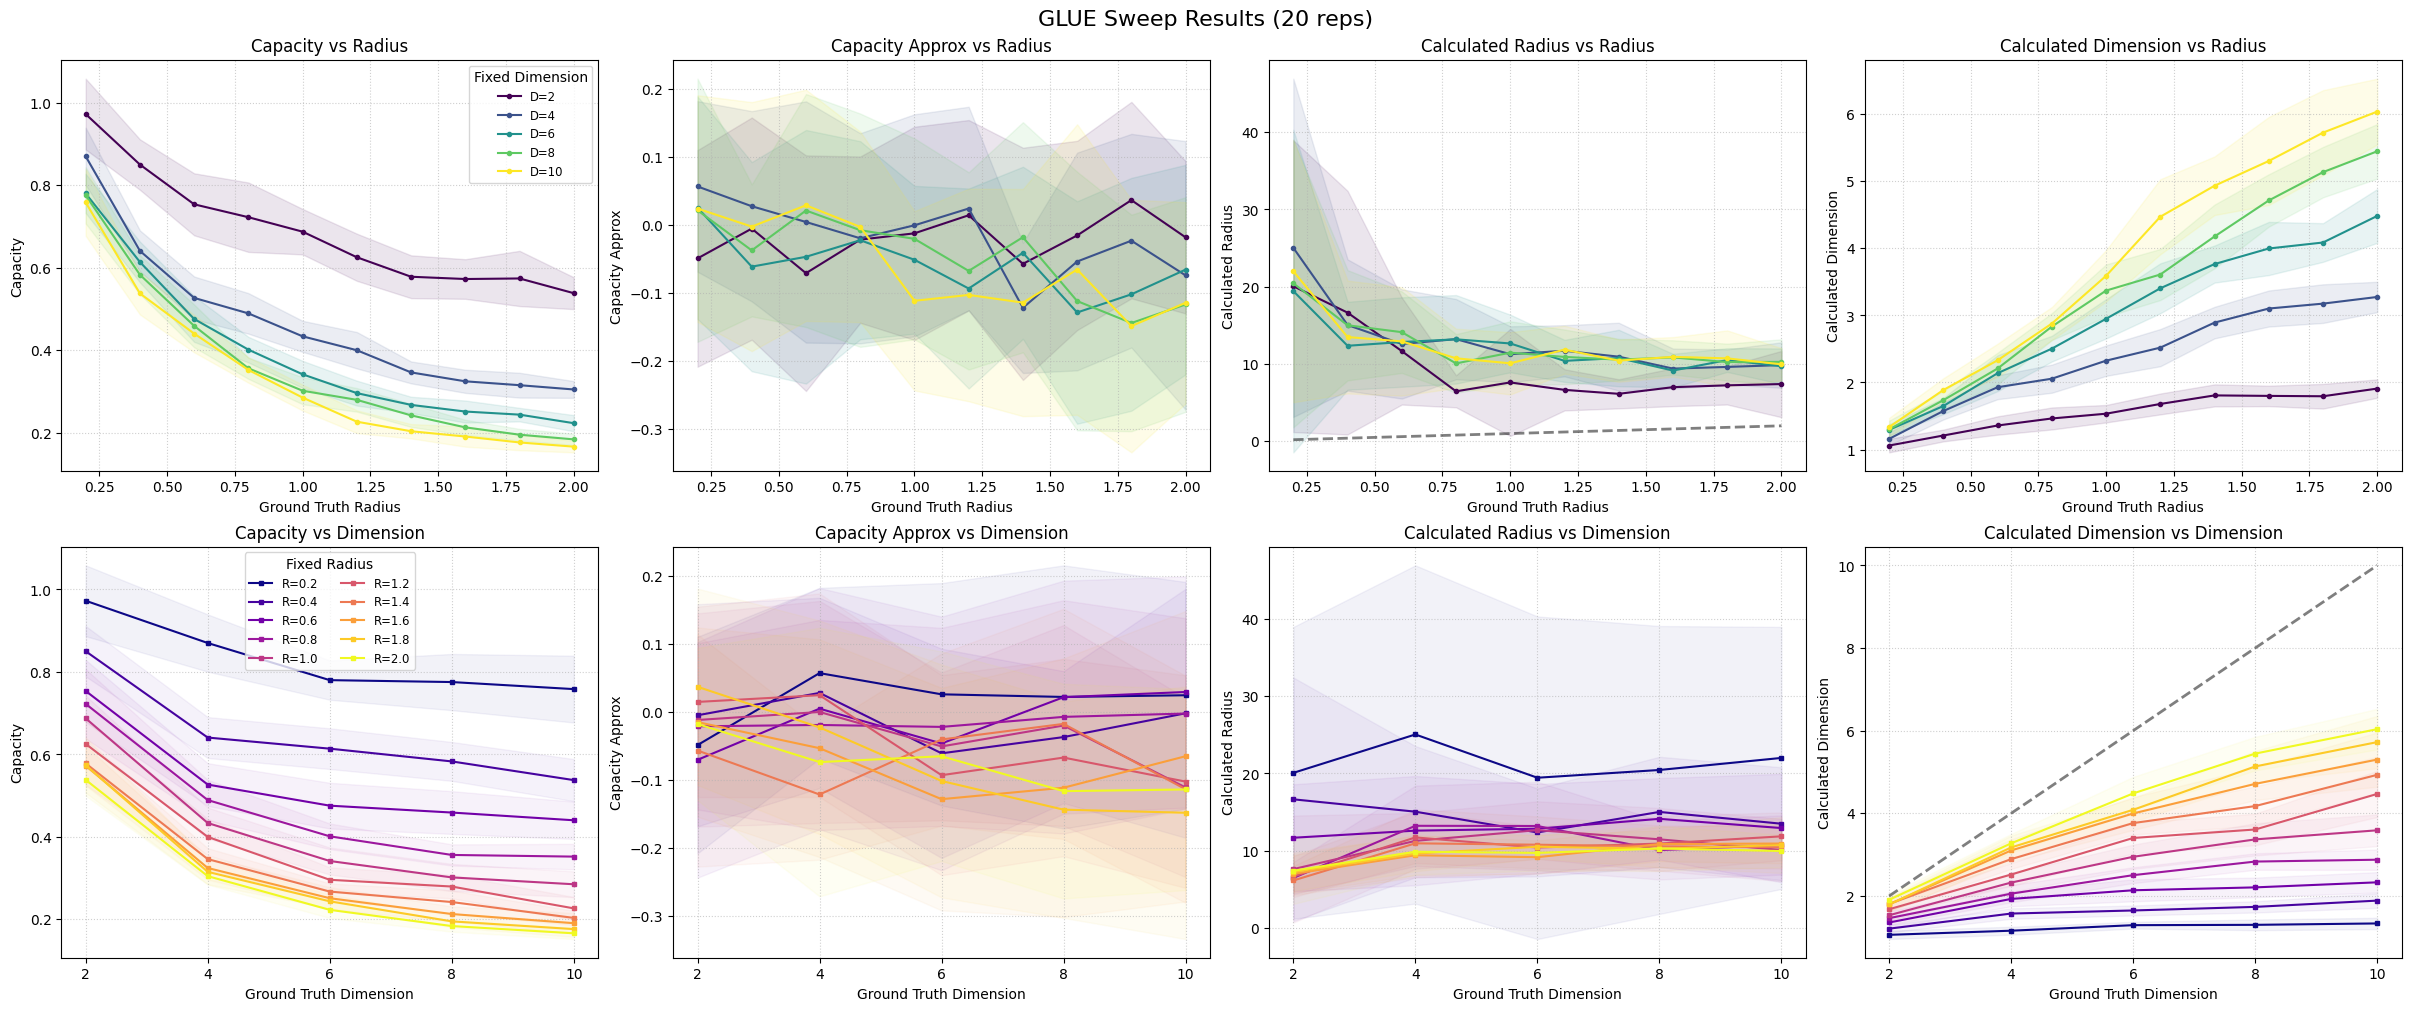

In [18]:
# --- Data Preparation ---
# Unpacking data from the results dictionary for easier access
radii_gt = results_grid['scan_radii']  # X-axis for Row 1
dims_gt = results_grid['scan_dims']    # X-axis for Row 2

# Organize metrics into a list of tuples: (Name, Mean_Array, Std_Array)
# Arrays are shape (n_dims, n_radii)
metrics_data = [
    ("Capacity", results_grid['grid_means_Cap'], results_grid['grid_stds_Cap']),
    ("Capacity Approx", results_grid['grid_means_CapApprox'], results_grid['grid_stds_CapApprox']),
    ("Calculated Radius", results_grid['grid_means_R'], results_grid['grid_stds_R']),
    ("Calculated Dimension", results_grid['grid_means_D'], results_grid['grid_stds_D'])
]

# --- Plotting Setup ---
fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)

# Color maps for distinct lines
cm_dims = plt.get_cmap('viridis')(np.linspace(0, 1, len(dims_gt)))
cm_radii = plt.get_cmap('plasma')(np.linspace(0, 1, len(radii_gt)))

# ==========================================
# ROW 1: X-axis = Ground Truth Radius
# Legend = Dimensions (Lines are fixed D)
# ==========================================
for col_idx, (name, mean_grid, std_grid) in enumerate(metrics_data):
    ax = axes[0, col_idx]
    
    # Iterate over Dimensions (rows of the grid)
    for i, D in enumerate(dims_gt):
        # Slice: Fix D (row i), vary R (all columns)
        y_mean = mean_grid[i, :]
        y_std = std_grid[i, :]
        
        ax.plot(radii_gt, y_mean, marker='o', markersize=3, 
                label=f'D={D}', color=cm_dims[i])
        
        # Optional: Shading for Std Dev
        ax.fill_between(radii_gt, y_mean - y_std, y_mean + y_std, 
                        color=cm_dims[i], alpha=0.1)

    # Reference Lines for Columns 3 and 4 (Radius and Dim)
    if col_idx == 2: # Calculated Radius vs GT Radius
        ax.plot(radii_gt, radii_gt, 'k--', alpha=0.5, linewidth=2, label='Identity (GT)')
    if col_idx == 3: # Calculated Dim vs GT Radius (Expected constant D lines)
        pass 

    ax.set_title(f"{name} vs Radius")
    ax.set_xlabel("Ground Truth Radius")
    ax.set_ylabel(name)
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Only add legend to the first plot to avoid clutter, or add outside
    if col_idx == 0:
        ax.legend(title="Fixed Dimension", fontsize='small')

# ==========================================
# ROW 2: X-axis = Ground Truth Dimension
# Legend = Radii (Lines are fixed R)
# ==========================================
for col_idx, (name, mean_grid, std_grid) in enumerate(metrics_data):
    ax = axes[1, col_idx]
    
    # Iterate over Radii (columns of the grid)
    for j, R in enumerate(radii_gt):
        # Slice: Fix R (col j), vary D (all rows)
        y_mean = mean_grid[:, j]
        y_std = std_grid[:, j]
        
        ax.plot(dims_gt, y_mean, marker='s', markersize=3, 
                label=f'R={R:.1f}', color=cm_radii[j])
        
        # Optional: Shading
        ax.fill_between(dims_gt, y_mean - y_std, y_mean + y_std, 
                        color=cm_radii[j], alpha=0.05)

    # Reference Lines
    if col_idx == 3: # Calculated Dim vs GT Dim
         ax.plot(dims_gt, dims_gt, 'k--', alpha=0.5, linewidth=2, label='Identity (GT)')

    ax.set_title(f"{name} vs Dimension")
    ax.set_xlabel("Ground Truth Dimension")
    ax.set_ylabel(name)
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Handle X-ticks for Dimensions (integers)
    ax.set_xticks(dims_gt)
    
    # Only add legend to the first plot of the row
    if col_idx == 0:
        ax.legend(title="Fixed Radius", fontsize='small', ncol=2)

# Global Title
fig.suptitle(f"GLUE Sweep Results ({n_reps} reps)", fontsize=16)

plt.show()